In [3]:
# AUTO CROPPING
import cv2
import numpy as np

In [4]:
input_path = '../data/input/test/DKN06476.jpg'
output_path = '../data/output/test/DKN06209_cropped.jpg'
image = cv2.imread(input_path)


In [5]:
# Read the image
image = cv2.imread(input_path)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply adaptive thresholding
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour (assuming it's the book)
largest_contour = max(contours, key=cv2.contourArea)

# Get the minimum area rectangle
rect = cv2.minAreaRect(largest_contour)
box = cv2.boxPoints(rect)
box = np.intp(box)

# Get width and height of the detected rectangle
width = int(rect[1][0])
height = int(rect[1][1])

src_pts = box.astype("float32")
# Coordinate of the points in box points after the rectangle has been straightened
dst_pts = np.array([[0, height - 1],
                    [0, 0],
                    [width - 1, 0],
                    [width - 1, height - 1]], dtype="float32")

# The perspective transformation matrix
M = cv2.getPerspectiveTransform(src_pts, dst_pts)

# Directly warp the rotated rectangle to get the straightened rectangle
warped = cv2.warpPerspective(image, M, (width, height))

# Add a small padding
padding = 5
warped = cv2.copyMakeBorder(warped, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=[255, 255, 255])

# Save the cropped image
cv2.imwrite(output_path, warped)

True

In [6]:
image_path = output_path
min_section_height = 50
line_thickness = 2
output_path = '../data/output/test/DKN06209_cropped_sections.jpg'

In [31]:
import os
from scipy.signal import find_peaks
from skimage.measure import label, regionprops

In [32]:
def split_textbook_image(image_path, min_region_size=1000, content_threshold=0.02):
    # Read the image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Edge detection
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Dilate edges to connect nearby lines
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=2)

    # Find horizontal and vertical lines
    def find_lines(image, axis):
        sums = np.sum(image, axis=axis)
        peaks, _ = find_peaks(sums, height=np.mean(sums), distance=50)
        return peaks

    horizontal_lines = find_lines(dilated, axis=1)
    vertical_lines = find_lines(dilated, axis=0)

    # Add image boundaries
    horizontal_lines = np.unique(np.concatenate(([0], horizontal_lines, [gray.shape[0]])))
    vertical_lines = np.unique(np.concatenate(([0], vertical_lines, [gray.shape[1]])))

    # Create initial regions
    regions = []
    for i in range(len(horizontal_lines) - 1):
        for j in range(len(vertical_lines) - 1):
            top = horizontal_lines[i]
            bottom = horizontal_lines[i + 1]
            left = vertical_lines[j]
            right = vertical_lines[j + 1]

            region = img[top:bottom, left:right]
            regions.append({"coords": (top, bottom, left, right), "image": region})

    # Merge small regions
    def merge_regions(regions):
        merged = []
        for region in regions:
            if cv2.countNonZero(cv2.cvtColor(region["image"], cv2.COLOR_BGR2GRAY)) > content_threshold * region[
                "image"].size and \
                    region["image"].shape[0] * region["image"].shape[1] >= min_region_size:
                merged.append(region)
            else:
                # Try to merge with neighboring regions
                for other in merged:
                    if (abs(region["coords"][0] - other["coords"][1]) <= 5 or  # vertically adjacent
                            abs(region["coords"][2] - other["coords"][3]) <= 5):  # horizontally adjacent
                        top = min(region["coords"][0], other["coords"][0])
                        bottom = max(region["coords"][1], other["coords"][1])
                        left = min(region["coords"][2], other["coords"][2])
                        right = max(region["coords"][3], other["coords"][3])
                        other["coords"] = (top, bottom, left, right)
                        other["image"] = img[top:bottom, left:right]
                        break
                else:
                    merged.append(region)
        return merged

    regions = merge_regions(regions)

    # Find any missed content
    mask = np.zeros(gray.shape, dtype=np.uint8)
    for region in regions:
        top, bottom, left, right = region["coords"]
        mask[top:bottom, left:right] = 255

    missed_content = cv2.bitwise_not(mask) & (gray < 250)  # Assuming light background
    labeled_missed = label(missed_content)
    props = regionprops(labeled_missed)

    for prop in props:
        if prop.area >= min_region_size:
            minr, minc, maxr, maxc = prop.bbox
            regions.append({
                "coords": (minr, maxr, minc, maxc),
                "image": img[minr:maxr, minc:maxc]
            })

    # Create final dictionary of regions
    final_regions = {}
    for i, region in enumerate(regions):
        final_regions[f"region_{i}"] = region["image"]

    return final_regions


In [58]:
def detect_regions(image_path, output_dir, min_contour_area=1000):
    # Read the image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply binary thresholding
    _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    regions = []
    idx = 0
    for cnt in contours:
        # Filter out small contours based on area
        if cv2.contourArea(cnt) > min_contour_area:
            x, y, w, h = cv2.boundingRect(cnt)
            region = image[y:y + h, x:x + w]
            regions.append(region)

            output_path = os.path.join(output_dir, f'region_{idx}.jpg')
            cv2.imwrite(output_path, region)
            print(f'{output_dir}/region_{idx}.jpg')
            idx += 1

    return regions

In [59]:
def save_regions(regions, output_dir):
    for name, region in regions.items():
        output_path = os.path.join(output_dir, f'cropped_image_{name}.jpg')
        cv2.imwrite(output_path, region)
        print(f"Saved cropped image {output_path}.jpg")

In [60]:
output_directory = "../data/output/test/DKN06209/sections"
regions = detect_regions(image_path, output_directory)
# save_regions(regions, output_directory)

../data/output/test/DKN06209/sections/region_0.jpg


In [63]:
import cv2
import pytesseract


def detect_text_regions(image_path):
    # Read the image
    img = cv2.imread(image_path)

    # Convert to RGB (Tesseract expects RGB images)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Use Tesseract to get bounding boxes for text
    data = pytesseract.image_to_data(img_rgb, output_type=pytesseract.Output.DICT)

    # Get dimensions of the image
    height, width, _ = img.shape

    # Lists to store paragraph and section bounding boxes
    paragraphs = []
    sections = []

    current_paragraph = None
    current_section = None

    # Process detected text regions
    for i in range(len(data['text'])):
        if int(data['conf'][i]) > 60:  # Consider only text with confidence > 60%
            (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])

            # Check if it's a new section (assuming larger font size for section headers)
            if h > 1.5 * data['height'][i - 1] if i > 0 else False:
                if current_section:
                    sections.append(current_section)
                current_section = {'x': x, 'y': y, 'w': w, 'h': h}

            # Update or create new paragraph
            if current_paragraph is None:
                current_paragraph = {'x': x, 'y': y, 'w': w, 'h': h}
            elif y > current_paragraph['y'] + current_paragraph['h'] + 10:  # New paragraph
                paragraphs.append(current_paragraph)
                current_paragraph = {'x': x, 'y': y, 'w': w, 'h': h}
            else:  # Extend current paragraph
                current_paragraph['w'] = max(current_paragraph['w'], x + w - current_paragraph['x'])
                current_paragraph['h'] = max(current_paragraph['h'], y + h - current_paragraph['y'])

    # Add last paragraph and section
    if current_paragraph:
        paragraphs.append(current_paragraph)
    if current_section:
        sections.append(current_section)

    # Draw bounding boxes
    for para in paragraphs:
        cv2.rectangle(img, (para['x'], para['y']), (para['x'] + para['w'], para['y'] + para['h']), (0, 255, 0), 2)

    for sect in sections:
        cv2.rectangle(img, (sect['x'], sect['y']), (sect['x'] + sect['w'], sect['y'] + sect['h']), (255, 0, 0), 2)

    # Save the image with bounding boxes

    return paragraphs, sections, img


In [62]:

# Example usage
output_dir = "../data/output/test/DKN06209/sections"
paragraphs, sections, img = detect_text_regions(image_path)
output_path = os.path.join(output_dir, f'cropped_image.jpg')
cv2.imwrite(output_path, img)
print(f"Detected {len(paragraphs)} paragraphs and {len(sections)} sections.")
print("The image with detected regions has been saved as 'detected_regions.jpg'")

Detected 3 paragraphs and 42 sections.
The image with detected regions has been saved as 'detected_regions.jpg'


In [ ]:
import cv2

# Load image, grayscale, Gaussian blur, Otsu's threshold, dilate
image = cv2.imread('1.jpg')
original = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (1, 1), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
dilate = cv2.dilate(thresh, kernel, iterations=2)

# Find contours, obtain bounding box coordinates, and extract ROI
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
image_number = 0
for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(image, (x, y), (x + w, y + h), (36, 255, 12), 3)
    ROI = original[y:y + h, x:x + w]
    cv2.imwrite("ROI_{}.png".format(image_number), ROI)
    image_number += 1

cv2.imshow('image', image)
cv2.imshow('thresh', thresh)
cv2.imshow('dilate', dilate)


In [8]:
import cv2
import os


def detect_and_split_pages(image_path):
    # Read the image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply thresholding
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Calculate vertical projection profile
    vertical_projection = np.sum(binary, axis=0)

    # Find potential split point
    split_point = np.argmin(vertical_projection)

    # Check if the split point is significant
    left_sum = np.sum(vertical_projection[:split_point])
    right_sum = np.sum(vertical_projection[split_point:])

    if min(left_sum, right_sum) / max(left_sum, right_sum) > 0.7:  # Adjust threshold as needed
        # Split the image
        left_page = img[:, :split_point]
        right_page = img[:, split_point:]
        return left_page, right_page
    else:
        return None, None  # No clear split detected

In [12]:
output_dir = "../data/output/test/DKN06209/sections"
left_page, right_page = detect_and_split_pages(image_path)
print(left_page)
left_output_path = os.path.join(output_dir, f'left.jpg')
right_output_path = os.path.join(output_dir, f'right.jpg')

if left_page:
    cv2.imwrite(left_output_path, left_page)

if right_page:
    cv2.imwrite(right_output_path, right_page)

None


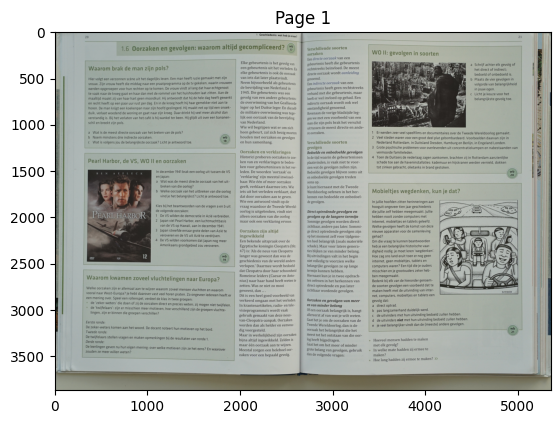

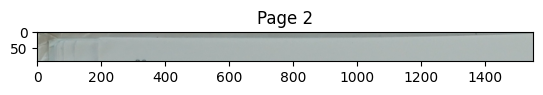

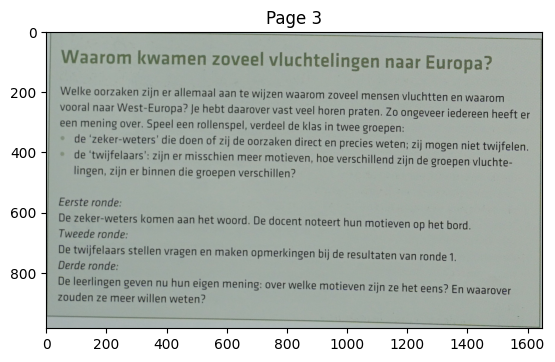

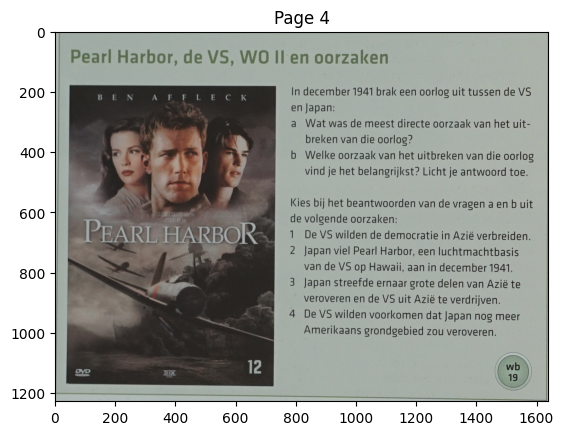

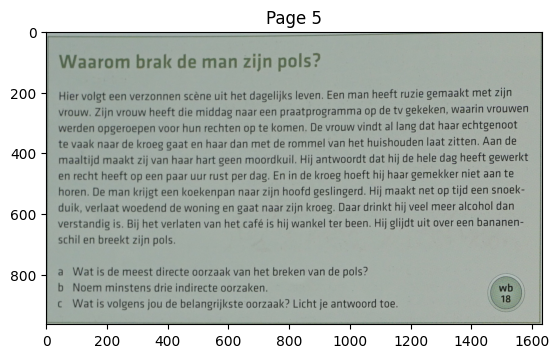

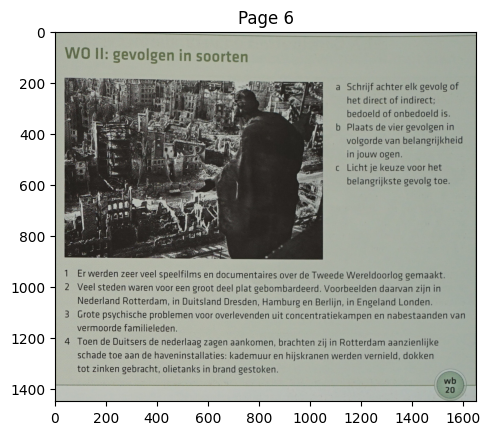

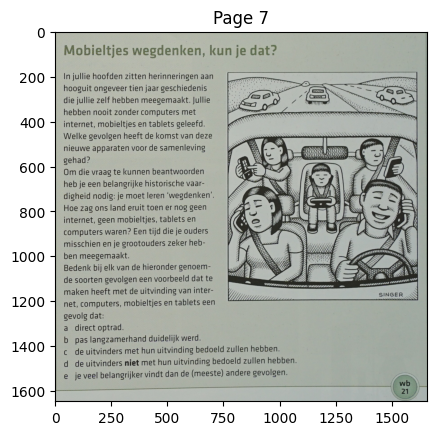

In [14]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the image
image_path = 'region_0.png'
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Threshold the image to get a binary image
_, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours based on their x-coordinate (to split pages from left to right)
contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

# Assume there are only two pages and split them
pages = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > image.shape[1] // 4:  # Heuristic to ignore small contours that are not pages
        page = image[y:y + h, x:x + w]
        pages.append(page)

# Save the split pages
for idx, page in enumerate(pages):
    cv2.imwrite(f'page_{idx + 1}.png', page)

# Display the results (optional)
for idx, page in enumerate(pages):
    plt.figure()
    plt.title(f'Page {idx + 1}')
    plt.imshow(cv2.cvtColor(page, cv2.COLOR_BGR2RGB))
    plt.show()
